In [1]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import optuna

from preprocessing import _downcast_dtypes, _load_userdf
from forecast.main.utils import create_same_length_instances, normalize_data, fill_nulls, create_instances_dl, create_instances_ml, create_random_samples

import warnings
warnings.simplefilter("ignore")

## Loading and preprocessing

In [3]:
# non-binarized labels (with 4)

X_data= np.load('./generated-datasets/stress/all_users_stress_8H_7days_dl_instances_X.npy')
y_data= np.load('./generated-datasets/stress/all_users_stress_8H_7days_dl_instances_y.npy')

print('Data shape :' + str(X_data.shape))


#drop neutral

neutral_indexes = [i for i, x in enumerate(y_data) if x == 4] 
new_indexes= [i for i in range(len(y_data)) if i not in neutral_indexes]

X=X_data[new_indexes]
new_y=y_data[new_indexes]

print('n_instances left = ' + str(len(new_y)))


#binarize
binarize=lambda x : 0 if x < 4 else 1
y=[binarize(x) for x in new_y]
y=np.array(y)


Data shape :(12315, 21, 37)
n_instances left = 9736


In [4]:
import random
def create_balanced_test_split(X,y,test_size=1000, seed= 1):
    
    random.seed(seed)
    all_one_indexes = [i for i, x in enumerate(y) if x == 1]
    all_zero_indexes = [i for i, x in enumerate(y) if x == 0]
    
    np.random.shuffle(all_zero_indexes)
    np.random.shuffle(all_one_indexes)


    train_indexes=all_zero_indexes[int(test_size/2):]+all_one_indexes[int(test_size/2):]
    test_indexes= all_zero_indexes[:int(test_size/2)]+all_one_indexes[:int(test_size/2)]

    x_train=X[train_indexes]
    y_train=y[train_indexes]

    x_test=X[test_indexes]
    y_test=y[test_indexes]
    
    return x_train, y_train, x_test, y_test
    

In [5]:
x_train, y_train, x_test, y_test=create_balanced_test_split(X, y, test_size=1000, seed=1)

In [ ]:
np.save("./generated-datasets/happy/happy_8H_7days_x_train.npy", x_train)
np.save("./generated-datasets/happy/happy_8H_7days_y_train.npy", y_train)
np.save("./generated-datasets/happy/happy_8H_7days_x_test.npy", x_test)
np.save("./generated-datasets/happy/happy_8H_7days_y_test.npy", y_test)

## Model architecture

In [6]:
np.sum(y)

4457

In [7]:
len(y)

9736

In [8]:
class_weight = {0: 5.425, 1: 1.}

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout

## LSTM - 1 layer - 32, 64 or 128 units - with or without Dense Layer and Bidirectionnal

In [10]:
hist_1_layer=[]

for n_unit in [32, 64, 128]:
    
    print(n_unit)
    
    
    for i in range (3):
        
        
        print(i)
        
        
        model = Sequential()
        model.add(Input(shape=X.shape[1:]))
        model.add(LSTM(n_unit, activation="tanh"))  #recurrent_dropout=0.25
        model.add(Dense(1, activation="sigmoid"))
    
        model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
        
        x_train, y_train, x_test, y_test=create_balanced_test_split(X,y,test_size=1000, seed= 1)
        
        history= model.fit(x=x_train,y=y_train,epochs=55,batch_size=32
                           ,validation_data=(x_test, y_test),shuffle=True,verbose=0)
        
        
        print('max train accuracy : ' + str(np.max(history.history['accuracy'])))
        print('epoch : ' + str(np.argmax(history.history['accuracy'])+1))

        
        print('max valid accuracy : ' + str(np.max(history.history['val_accuracy'])))
        print('epoch : ' + str(np.argmax(history.history['val_accuracy'])+1))
        
        
        
        hist_1_layer.append(history)
        

32
0
max train accuracy : 0.978708803653717
epoch : 52
max valid accuracy : 0.7490000128746033
epoch : 23
1
max train accuracy : 0.980998158454895
epoch : 55
max valid accuracy : 0.7289999723434448
epoch : 26
2
max train accuracy : 0.9726419448852539
epoch : 55
max valid accuracy : 0.7300000190734863
epoch : 27
64
0
max train accuracy : 0.9990842342376709
epoch : 55
max valid accuracy : 0.7559999823570251
epoch : 15
1
max train accuracy : 0.9988552927970886
epoch : 48
max valid accuracy : 0.7419999837875366
epoch : 39
2
max train accuracy : 0.9985119104385376
epoch : 52
max valid accuracy : 0.7570000290870667
epoch : 12
128
0
max train accuracy : 0.9993131756782532
epoch : 45
max valid accuracy : 0.75
epoch : 9
1
max train accuracy : 0.9993131756782532
epoch : 49
max valid accuracy : 0.753000020980835
epoch : 45
2
max train accuracy : 0.9993131756782532
epoch : 55
max valid accuracy : 0.7590000033378601
epoch : 17


In [11]:
hist_1_layer_drop_fc=[]

for n_unit in [32, 64, 128]:
    
    print(n_unit)
    
    
    for i in range (3):
        
        
        print(i)
        
        
        model = Sequential()
        model.add(Input(shape=X.shape[1:]))
        model.add(LSTM(n_unit, activation="tanh", dropout=0.25, recurrent_dropout=0.25))  #recurrent_dropout=0.25
        model.add(Dense(n_unit, activation="relu"))
        model.add(Dropout(0.25))

        model.add(Dense(1, activation="sigmoid"))
    
        model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
        
        x_train, y_train, x_test, y_test=create_balanced_test_split(X,y,test_size=1000, seed= 1)
        
        history= model.fit(x=x_train,y=y_train,epochs=55,batch_size=32
                           ,validation_data=(x_test, y_test),shuffle=True,verbose=0)
        
        
        print('max train accuracy : ' + str(np.max(history.history['accuracy'])))
        print('epoch : ' + str(np.argmax(history.history['accuracy'])+1))

        
        print('max valid accuracy : ' + str(np.max(history.history['val_accuracy'])))
        print('epoch : ' + str(np.argmax(history.history['val_accuracy'])+1))
        
        
        
        hist_1_layer_drop_fc.append(history)

32
0
max train accuracy : 0.8115842342376709
epoch : 52
max valid accuracy : 0.753000020980835
epoch : 55
1
max train accuracy : 0.8099817037582397
epoch : 55
max valid accuracy : 0.7400000095367432
epoch : 45
2
max train accuracy : 0.8171932101249695
epoch : 52
max valid accuracy : 0.7599999904632568
epoch : 38
64
0
max train accuracy : 0.8803800344467163
epoch : 55
max valid accuracy : 0.7379999756813049
epoch : 50
1
max train accuracy : 0.8799221515655518
epoch : 54
max valid accuracy : 0.7450000047683716
epoch : 42
2
max train accuracy : 0.8864468932151794
epoch : 55
max valid accuracy : 0.7580000162124634
epoch : 42
128
0
max train accuracy : 0.9404761791229248
epoch : 55
max valid accuracy : 0.7580000162124634
epoch : 18
1
max train accuracy : 0.9452838897705078
epoch : 53
max valid accuracy : 0.7250000238418579
epoch : 47
2
max train accuracy : 0.9391025900840759
epoch : 53
max valid accuracy : 0.7760000228881836
epoch : 17


In [12]:
hist_1_layer_drop_fc_bi=[]

for n_unit in [32, 64, 128]:
    
    print(n_unit)
    
    
    for i in range (3):
        
        
        print(i)
        
        
        model = Sequential()
        model.add(Input(shape=X.shape[1:]))
        model.add(Bidirectional(LSTM(n_unit, activation="tanh", dropout=0.25, recurrent_dropout=0.25)))  #recurrent_dropout=0.25
        model.add(Dense(n_unit, activation="relu"))
        model.add(Dropout(0.25))

        model.add(Dense(1, activation="sigmoid"))
    
        model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
        
        x_train, y_train, x_test, y_test=create_balanced_test_split(X,y,test_size=1000, seed= 1)
        
        history= model.fit(x=x_train,y=y_train,epochs=55,batch_size=32
                           ,validation_data=(x_test, y_test),shuffle=True,verbose=0)
        
        
        print('max train accuracy : ' + str(np.max(history.history['accuracy'])))
        print('epoch : ' + str(np.argmax(history.history['accuracy'])+1))

        
        print('max valid accuracy : ' + str(np.max(history.history['val_accuracy'])))
        print('epoch : ' + str(np.argmax(history.history['val_accuracy'])+1))
        
        
        
        hist_1_layer_drop_fc_bi.append(history)

32
0
max train accuracy : 0.865613579750061
epoch : 52
max valid accuracy : 0.7459999918937683
epoch : 23
1
max train accuracy : 0.8551968932151794
epoch : 46
max valid accuracy : 0.7580000162124634
epoch : 52
2
max train accuracy : 0.8605769276618958
epoch : 55
max valid accuracy : 0.7540000081062317
epoch : 24
64
0
max train accuracy : 0.9290292859077454
epoch : 52
max valid accuracy : 0.7419999837875366
epoch : 53
1
max train accuracy : 0.9296016693115234
epoch : 55
max valid accuracy : 0.7450000047683716
epoch : 22
2
max train accuracy : 0.928113579750061
epoch : 52
max valid accuracy : 0.7480000257492065
epoch : 30
128
0
max train accuracy : 0.9711538553237915
epoch : 51
max valid accuracy : 0.7239999771118164
epoch : 19
1
max train accuracy : 0.9689789414405823
epoch : 54
max valid accuracy : 0.7710000276565552
epoch : 27
2
max train accuracy : 0.9692078828811646
epoch : 54
max valid accuracy : 0.7480000257492065
epoch : 15


<BarContainer object of 9 artists>

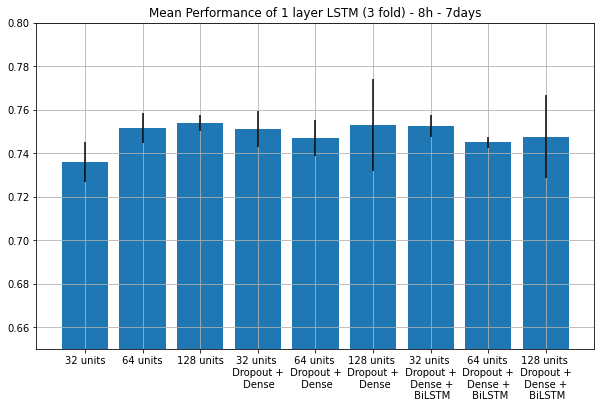

In [13]:
import matplotlib.pyplot as plt

x = ['32 units', '64 units', '128 units',
     '32 units \n Dropout + \n Dense', '64 units \n Dropout + \n Dense', '128 units \n Dropout + \n Dense',
     '32 units \n Dropout + \n  Dense + \n BiLSTM', '64 units \n Dropout + \n Dense + \n BiLSTM', '128 units \n Dropout + \n Dense + \n BiLSTM']


y = [np.mean([np.max(hist_1_layer[0].history['val_accuracy']),np.max(hist_1_layer[1].history['val_accuracy']),np.max(hist_1_layer[2].history['val_accuracy'])]),
     np.mean([np.max(hist_1_layer[3].history['val_accuracy']),np.max(hist_1_layer[4].history['val_accuracy']),np.max(hist_1_layer[5].history['val_accuracy'])]),
     np.mean([np.max(hist_1_layer[6].history['val_accuracy']),np.max(hist_1_layer[7].history['val_accuracy']),np.max(hist_1_layer[8].history['val_accuracy'])]),
     np.mean([np.max(hist_1_layer_drop_fc[0].history['val_accuracy']),np.max(hist_1_layer_drop_fc[1].history['val_accuracy']),np.max(hist_1_layer_drop_fc[2].history['val_accuracy'])]),
     np.mean([np.max(hist_1_layer_drop_fc[3].history['val_accuracy']),np.max(hist_1_layer_drop_fc[4].history['val_accuracy']),np.max(hist_1_layer_drop_fc[5].history['val_accuracy'])]),
     np.mean([np.max(hist_1_layer_drop_fc[6].history['val_accuracy']),np.max(hist_1_layer_drop_fc[7].history['val_accuracy']),np.max(hist_1_layer_drop_fc[8].history['val_accuracy'])]),
     np.mean([np.max(hist_1_layer_drop_fc_bi[0].history['val_accuracy']),np.max(hist_1_layer_drop_fc_bi[1].history['val_accuracy']),np.max(hist_1_layer_drop_fc_bi[2].history['val_accuracy'])]),
     np.mean([np.max(hist_1_layer_drop_fc_bi[3].history['val_accuracy']),np.max(hist_1_layer_drop_fc_bi[4].history['val_accuracy']),np.max(hist_1_layer_drop_fc_bi[5].history['val_accuracy'])]),
     np.mean([np.max(hist_1_layer_drop_fc_bi[6].history['val_accuracy']),np.max(hist_1_layer_drop_fc_bi[7].history['val_accuracy']),np.max(hist_1_layer_drop_fc_bi[8].history['val_accuracy'])])]
    

err= [np.std([np.max(hist_1_layer[0].history['val_accuracy']),np.max(hist_1_layer[1].history['val_accuracy']),np.max(hist_1_layer[2].history['val_accuracy'])]),
     np.std([np.max(hist_1_layer[3].history['val_accuracy']),np.max(hist_1_layer[4].history['val_accuracy']),np.max(hist_1_layer[5].history['val_accuracy'])]),
     np.std([np.max(hist_1_layer[6].history['val_accuracy']),np.max(hist_1_layer[7].history['val_accuracy']),np.max(hist_1_layer[8].history['val_accuracy'])]),
     np.std([np.max(hist_1_layer_drop_fc[0].history['val_accuracy']),np.max(hist_1_layer_drop_fc[1].history['val_accuracy']),np.max(hist_1_layer_drop_fc[2].history['val_accuracy'])]),
     np.std([np.max(hist_1_layer_drop_fc[3].history['val_accuracy']),np.max(hist_1_layer_drop_fc[4].history['val_accuracy']),np.max(hist_1_layer_drop_fc[5].history['val_accuracy'])]),
     np.std([np.max(hist_1_layer_drop_fc[6].history['val_accuracy']),np.max(hist_1_layer_drop_fc[7].history['val_accuracy']),np.max(hist_1_layer_drop_fc[8].history['val_accuracy'])]),
     np.std([np.max(hist_1_layer_drop_fc_bi[0].history['val_accuracy']),np.max(hist_1_layer_drop_fc_bi[1].history['val_accuracy']),np.max(hist_1_layer_drop_fc_bi[2].history['val_accuracy'])]),
     np.std([np.max(hist_1_layer_drop_fc_bi[3].history['val_accuracy']),np.max(hist_1_layer_drop_fc_bi[4].history['val_accuracy']),np.max(hist_1_layer_drop_fc_bi[5].history['val_accuracy'])]),
     np.std([np.max(hist_1_layer_drop_fc_bi[6].history['val_accuracy']),np.max(hist_1_layer_drop_fc_bi[7].history['val_accuracy']),np.max(hist_1_layer_drop_fc_bi[8].history['val_accuracy'])])]
    

plt.figure(figsize=(10, 6))
plt.title('Mean Performance of 1 layer LSTM (3 fold) - 8h - 7days')
plt.ylim([0.65,0.80])
plt.grid()

plt.bar(x, y, yerr=err)

In [14]:
np.save("D:/.coding/means_stress.npy", y)
np.save("D:/.coding/error_stress.npy", err)

In [ ]:
hist_1_layer_drop_fc_bi=[]

best_model = Sequential()
best_model.add(Input(shape=X.shape[1:]))
best_model.add(Bidirectional(LSTM(64, activation="tanh", dropout=0.25, recurrent_dropout=0.25)))  #recurrent_dropout=0.25
best_model.add(Dense(64, activation="relu"))
best_model.add(Dropout(0.25))

best_model.add(Dense(1, activation="sigmoid"))
    
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
#x_train, y_train, x_test, y_test=create_balanced_test_split(X, y, test_size=1000, seed= 1)
        
history = best_model.fit(x=x_train,y=y_train,epochs=55,batch_size=32,
                        validation_data=(x_test, y_test),shuffle=True,verbose=0)
                
print('max train accuracy : ' + str(np.max(history.history['accuracy'])))
print('epoch : ' + str(np.argmax(history.history['accuracy'])+1))
        
print('max valid accuracy : ' + str(np.max(history.history['val_accuracy'])))
print('epoch : ' + str(np.argmax(history.history['val_accuracy'])+1))
        
hist_1_layer_drop_fc_bi.append(history)

In [ ]:
best_model.save("./model_logs/best_happy_LSTM")